# ReTrain ReTest Ranger_04 with respect.unordered.factors=TRUE
https://win-vector.com/2016/05/30/on-ranger-respect-unordered-factors/

In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)

getwd()

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_05_moredata"

In [12]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')


# source('../phaseII_03_forest/load_prep_data_expiry.R')

# expiry_train_prepped_2_1 (list, less df's w/ 0 obs)
# expiry_test_prepped_2_1  (list, less df's w/ 0 obs)
# expiry_train_df_1 (above, rbound)
# expiry_test_df_1 (above, rbound)
# expiry_train_df_sub (subset vars)                                        
# expiry_test_df_sub (subset vars)

In [4]:
ls()

[1] "apply_standard_adjustments"         "basic_prep_domain_data"            
 [3] "build_model_first_renewal"          "build_model_first_renewal_agg"     
 [5] "build_model_first_renewal_agg_plus" "build_model_first_renewal_reg"     
 [7] "build_model_second_renewal"         "calc_auc"                          
 [9] "change.colnames"                    "chart_lift"                        
[11] "expiry_test_df_1"                   "expiry_test_df_sub"                
[13] "expiry_test_prepped_2"              "expiry_test_prepped_2_1"           
[15] "expiry_train_df_1"                  "expiry_train_df_sub"               
[17] "expiry_train_prepped_2"             "expiry_train_prepped_2_1"          
[19] "get_cluster_data"                   "get_cluster_large"                 
[21] "get_df_npv"                         "get_domain_npv"                    
[23] "get_domain_type"                    "get_pattern_score"                 
[25] "get_renewal_status"                 "intersect2"                        
[27] "list_predict_first_renewal"         "list_predict_second_renewal"       
[29] "mass_build_model_first_renewal"     "mass_build_model_second_renewal"   
[31] "mass_predict_first_renewal"         "mass_predict_second_renewal"       
[33] "mass_prep_data"                     "na.zero"                           
[35] "newreg_data_prep"                   "newreg_data_rename"                
[37] "newreg_data_select"                 "plot_gains"                        
[39] "plot_multigains"                    "predict_first_renewal"             
[41] "predict_first_renewal_agg"          "predict_first_renewal_agg_plus"    
[43] "predict_first_renewal_reg"          "predict_second_renewal"            
[45] "prep_domain_data"                   "save_object"                       
[47] "unzip.file"

In [5]:
num_trees = 1000
train = expiry_train_df_1
test = expiry_test_df_1

In [6]:
cat("\nTraining & Testing remaining aggregate forest.\n")

ranger_03_expiry2_f <- ranger( formula         = renewal_status ~ 
                             tld + reseller + reseller_country + 
                             region + reg_period + sld_type + sld_length + day_domains + 
                             gibb_score + pattern_domain_count + reg_arpt,
                             data            = train, 
                             importance      = 'impurity', 
                             num.trees       = num_trees,
                             probability     = TRUE,
                            #     mtry            = 3,
                            #     min.node.size   = 10,
                            #     replace         = FALSE,
                            #     sample.fraction = .8,
                             seed            = 123,
                             respect.unordered.factors=TRUE
)

predict_ranger_03_expiry2_f <- predict(ranger_03_expiry2_f, 
                                 data = test,
                                 type="response")$predictions

predict_ranger_03_expiry2_f <- as.data.frame(predict_ranger_03_expiry2_f)$Renewed


Training & Testing remaining aggregate forest.
Growing trees.. Progress: 3%. Estimated remaining time: 19 minutes, 21 seconds.
Growing trees.. Progress: 6%. Estimated remaining time: 17 minutes, 22 seconds.
Growing trees.. Progress: 9%. Estimated remaining time: 17 minutes, 13 seconds.
Growing trees.. Progress: 12%. Estimated remaining time: 16 minutes, 25 seconds.
Growing trees.. Progress: 14%. Estimated remaining time: 15 minutes, 57 seconds.
Growing trees.. Progress: 18%. Estimated remaining time: 15 minutes, 14 seconds.
Growing trees.. Progress: 20%. Estimated remaining time: 14 minutes, 54 seconds.
Growing trees.. Progress: 23%. Estimated remaining time: 14 minutes, 9 seconds.
Growing trees.. Progress: 26%. Estimated remaining time: 13 minutes, 34 seconds.
Growing trees.. Progress: 29%. Estimated remaining time: 12 minutes, 59 seconds.
Growing trees.. Progress: 32%. Estimated remaining time: 12 minutes, 25 seconds.
Growing trees.. Progress: 36%. Estimated remaining time: 11 minut

In [7]:
test$first_renewal_prediction <- predict_ranger_03_expiry2_f

df = data.frame("actual" = test$renewal_status,
          "predicted" = test$first_renewal_prediction)

lift_df <- chart_lift(pred_df = df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot <- plot_gains (lift_df) 

auc_val <- calc_auc(lift_df)

In [10]:
auc_val

[1] 0.8326662

In [8]:
save(ranger_03_expiry2_f, file="../../data/output/ranger_03_expiry2_f")
save(predict_ranger_03_expiry2_f, file="../../data/output/predict_ranger_03_expiry2_f")

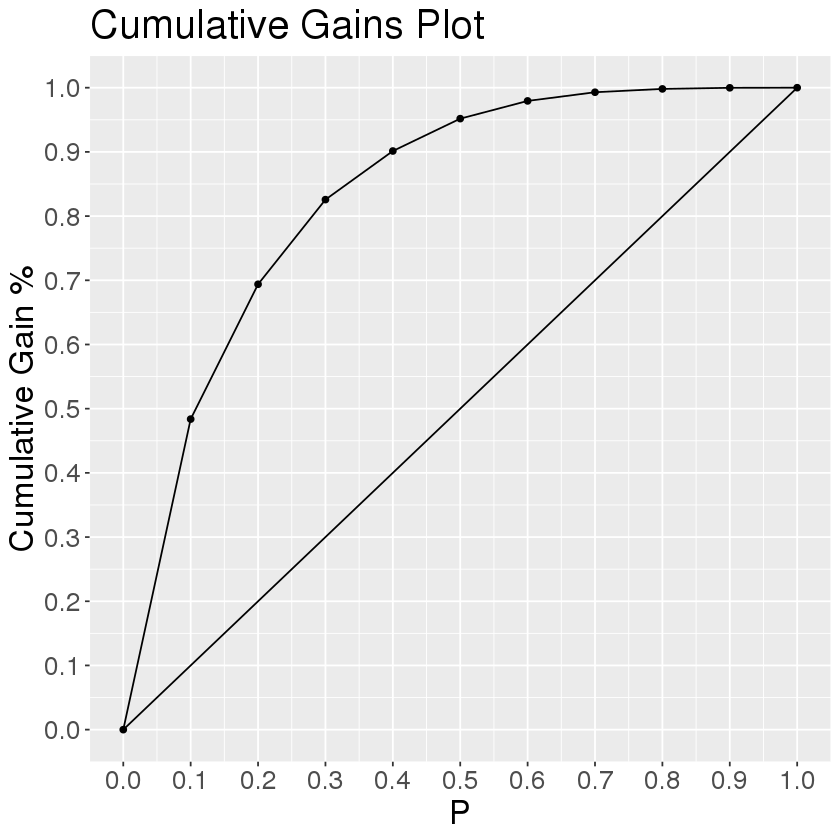

In [9]:
gains_plot

In [11]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,13136,0.4837415,4.837415
0.2,18840,0.6937949,3.468974
0.3,22421,0.8256675,2.752225
0.4,24477,0.9013810,2.253452
0.5,25846,0.9517952,1.903590
0.6,26596,0.9794145,1.632357
0.7,26963,0.9929295,1.418471
0.8,27104,0.9981219,1.247652
0.9,27150,0.9998159,1.110907


In [13]:
lift_df_seg_glm_expiry_exptest <- readRDS('../../data/lift_df_seg_glm_expiry_exptest')
plot_multigains <- plot_multigains(
    lift_df_list=list(
        agg_rf_f = lift_df,
        seg_glm = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        agg_rf = calc_auc(lift_df),
        seg_glm = calc_auc(lift_df_seg_glm_expiry_exptest)))
png(file = "../../data/output/plot_multigains_03_f.png",
    width = 500, height = 375)
plot(plot_multigains)
dev.off()

png 
  2

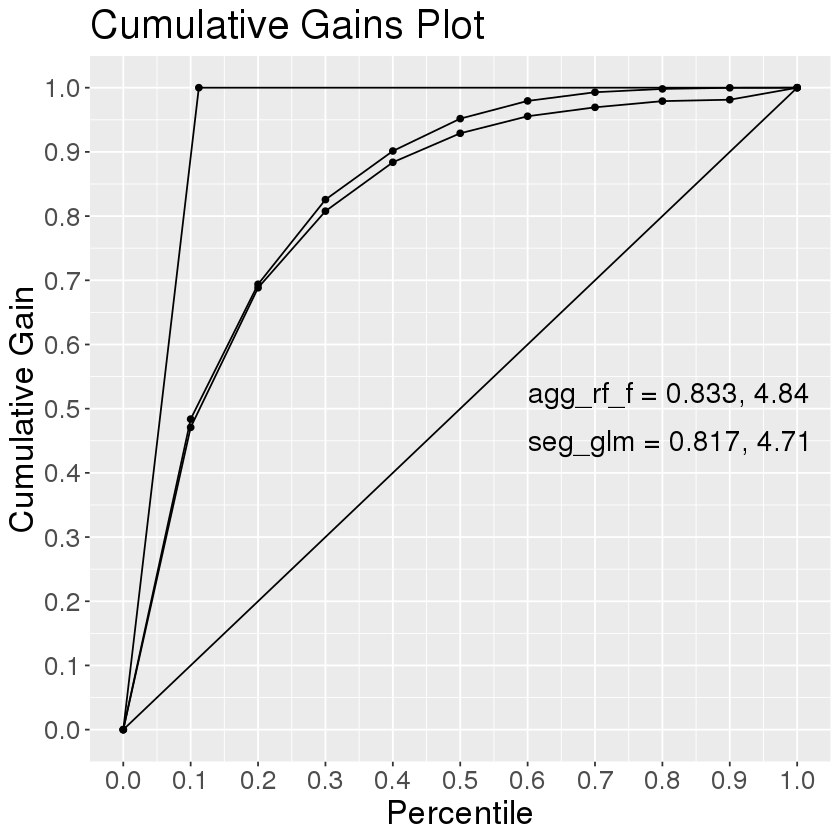

In [14]:
plot(plot_multigains)

In [16]:
lift_df

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,13136,0.4837415,4.837415
0.2,18840,0.6937949,3.468974
0.3,22421,0.8256675,2.752225
0.4,24477,0.9013810,2.253452
0.5,25846,0.9517952,1.903590
0.6,26596,0.9794145,1.632357
0.7,26963,0.9929295,1.418471
0.8,27104,0.9981219,1.247652
0.9,27150,0.9998159,1.110907


# Copy to Cloud Storage

In [15]:
system("gsutil cp /home/jupyter/local/Domains_202003/data/output/* gs://data_outputt/output/")
system("mv /home/jupyter/local/Domains_202003/data/output/* /home/jupyter/local/Domains_202003/data/")